# Infection state prediction using generic channels

In this notebook I will try to predict an event's infection state using data from the generic channels (brightfield, side scatter / dark field and DAPI). The ground truth infection state has been manually gated based on a stain for MCP (= the viral probe), and for PSBA (= metabolic activity probe). the infection states are:
- MCP-/PSBA+ (= uninfected and showing metabolic activity)
- MCP+/PSBA+ (= infected and showing metabolic activity)
- MCP+/PSBA- (= infected and no longer showing metabolic activity)
- MCP-/PSBA- (= dead)

The features used to do this classification are derived from the images using two tools: IDEAS and SCIP. IDEAS is a proprietary software specifically designed for analysing ImageStream data. SCIP is an open-source software developed by me, aimed at providing image processing at scale. The features computed by both softwares are similar in nature.

Notes on the feature names of SCIP:
- If a feature name contains 'combined', it means it is computed on the combination of all channel masks (just like 'mc' in IDEAS features).
- If a feature name contains 'bgcorr', it means it is computed on the background substracted values of the image. This means the mean background pixel value is substracted from the pixels in the mask prior to feature computation.
- If a feature name containts 'edge', it means it is computed using the pixels that are on the edge of the mask.
- The SCIP bgcorr 'sum' features are the same as the IDEAS 'intensity' features. Both are computed by summing the background corrected pixel values in the mask.

# Package imports

In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# %load common_.py
from common import *

In [168]:
import fcsparser
from ehv import feature_comparison, core
import flowutils
import shap
shap.initjs()

In [169]:
from sklearn.base import clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [170]:
from multiprocessing import Pool
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from scipy.stats import spearmanr

# Data import

Feature values from SCIP and IDEAS are imported. In total we import 133354 features.

In [171]:
data_dir = Path(os.environ["HOME"]) / "scratch/data/ehv"

In [15]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2"

In [180]:
df_scip = pq.read_table(data_dir / f"results/scip/202201311209_Inf/features.parquet").to_pandas()
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip = df_scip[numpy.load(data_dir / "results/scip/202201311209_Inf/columns.npy", allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(data_dir / "results/scip/202201311209_Inf/index.npy", allow_pickle=True)]
df_scip.shape

(33712, 1132)

In [182]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(33712, 1132)

In [183]:
df_scip = df_scip.drop(columns=df_scip.filter(regex="BF2$"))
df_scip.shape

(33712, 954)

In [184]:
# ideas features
tmp = []
for p in Path(data_dir / "results/ideas/202111031041/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(144421, 159)

In [185]:
df_ideas = df_ideas.drop(columns=df_ideas.filter(regex=".*(mcp|ch4).*").columns)
df_ideas.shape

(144421, 157)

In [186]:
df_scip = df_scip.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_group"])
df_ideas = df_ideas.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_group"])

In [192]:
df_ideas.index[0]

('Inf', 150, 1, 4)

In [193]:
df = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    on=["meta_type", "meta_object_number", "meta_replicate", "meta_group"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)
df.shape

(33107, 1103)

In [194]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df = df.rename(columns=rename)

In [195]:
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-", "unknown"], ordered=True)

# Feature comparison between IDEAS and SCIP

I compare the intensity features computed in SCIP and IDEAS in order to assess the quality of the SCIP features. I expect that they are highly correlated.

## TMR Intensity

Correlation is high.

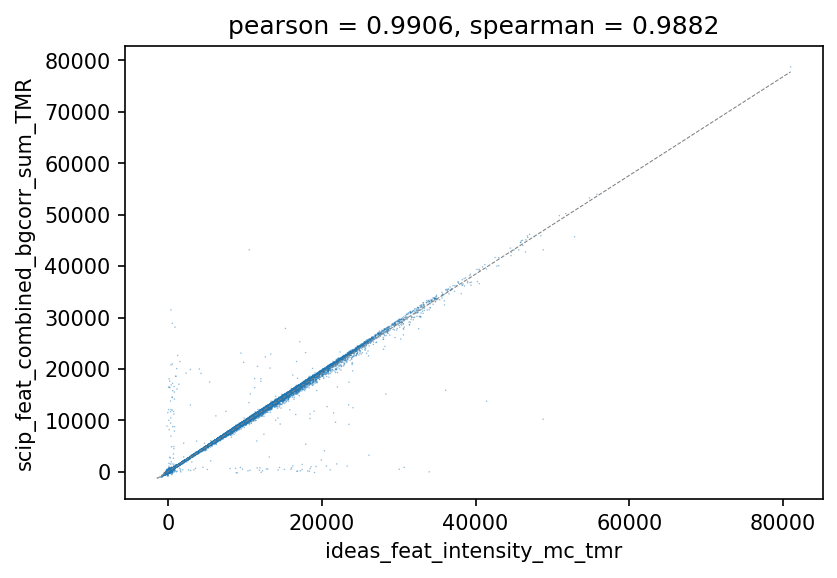

In [196]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_tmr", "scip_feat_combined_bgcorr_sum_TMR")

## BF intensity

For this channel correlation is lower. I am not yet sure why. For now I continue with these values, but they might be updated later.

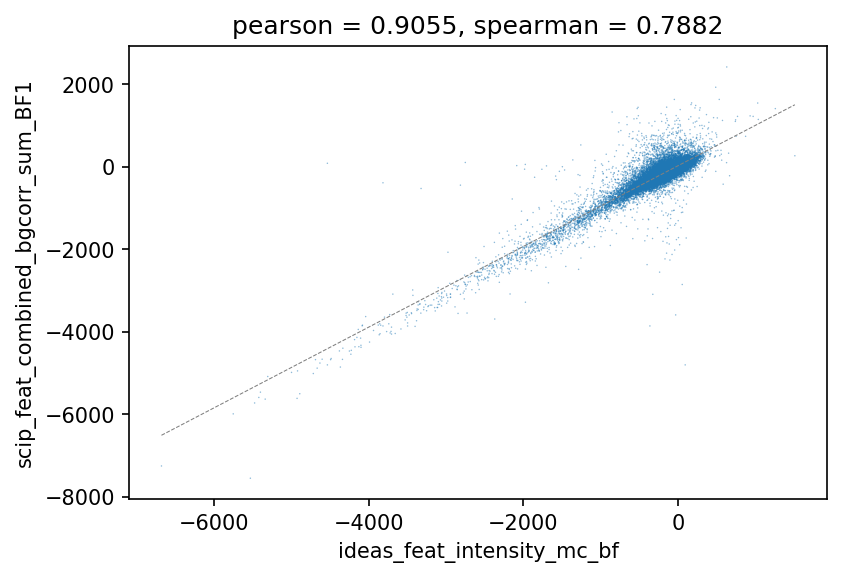

In [197]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_bf", "scip_feat_combined_bgcorr_sum_BF1")

## DAPI Intensity

Correlation is very good.

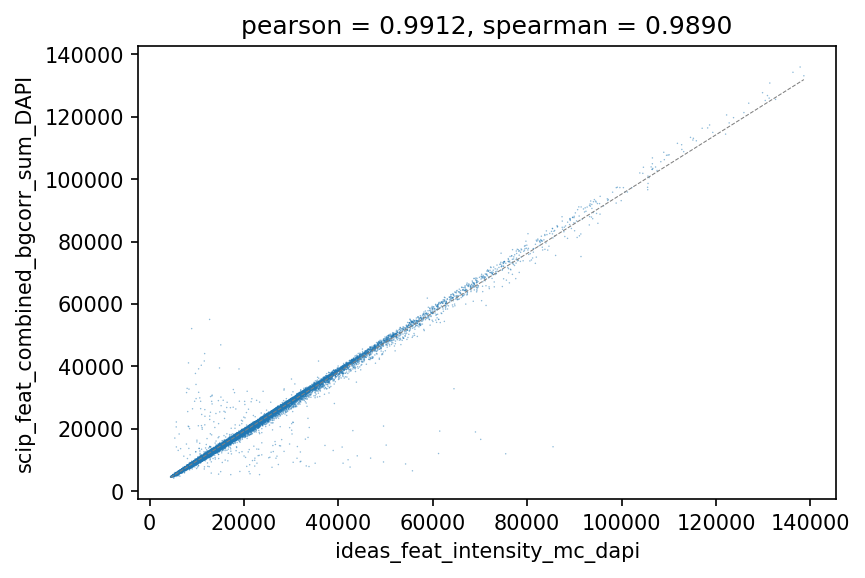

In [198]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_dapi", "scip_feat_combined_bgcorr_sum_DAPI")

## Cy5 Intensity

Correlation is very good.

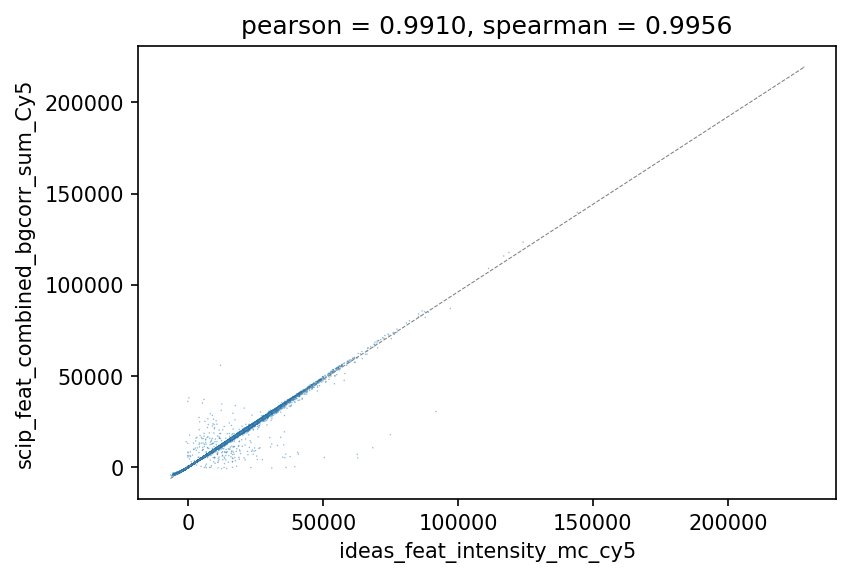

In [199]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_cy5", "scip_feat_combined_bgcorr_sum_Cy5")

# Continue with events assigned to cell states

I filter out the events falling between manual gates. This is only a small amount of events

In [200]:
df = df[df["meta_label"] != "unknown"]
df.shape

(31236, 1103)

In [201]:
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)

# Predicting IDEAS manual gates from all fluorescence intensity features

This is a baseline _sanity check_. Classification metrics should all be very high, since the manual gates have been set on the fluorescence intensity features using relatively simple rules (bisections or circular gates).

In [22]:
def predict_gates(X, y, model, seed=42):
    numpy.random.seed(seed)
    
    scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
    cv_results = cross_validate(
        estimator=model,
        X=X.values, y=y, cv=5,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
        n_jobs=5,
        verbose=0
    )
    cv_df = pandas.DataFrame(
        data = {
            **{"phase": ["train"] * 5 + ["test"] * 5},
            **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
        }
    ).melt(id_vars=["phase"])
    seaborn.stripplot(data=cv_df, y="variable", x="value", hue="phase", jitter=0)
    return cv_df

In [23]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

Class imabalance is quite high. This should be taken into account later on.

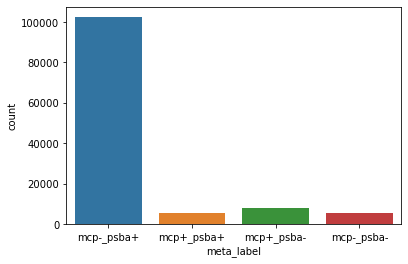

In [24]:
seaborn.countplot(x=df["meta_label"])

The below plots show the cross-validation results for a decision tree classifier trained to classify the infection states. Each dot corresponds to a random split of the data in training and testing data. The orange dots show each metric computed on the test data. As expected, all metrics are very high.

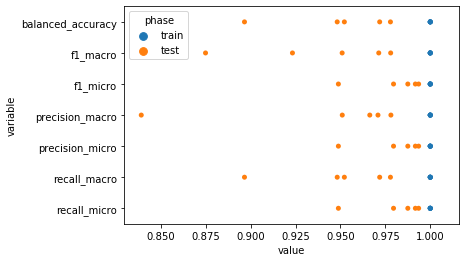

In [25]:
model = tree.DecisionTreeClassifier(class_weight="balanced")
_ = predict_gates(
    df.filter(regex="scip_feat_combined_bgcorr.*sum.*"), y, 
    model
)

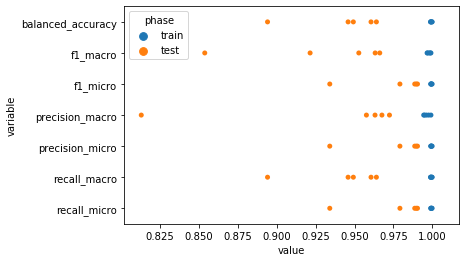

In [26]:
from sklearn import tree
model = tree.DecisionTreeClassifier(class_weight="balanced")
_ = predict_gates(
    df.filter(regex="ideas_feat_intensity_m.*"), y, 
    model
)

# Quality control plots of fluorescence channels control and infected samples

Here I show some stripplots with two strips per timepoint, one for the controls and one for the infected samples. The quality of the data looks good: Control samples are steady for the TMR, DAPI and Cy5 channels. The infected samples are steady for the DAPI channel and show the expected patterns for the TMR and Cy5 channels.

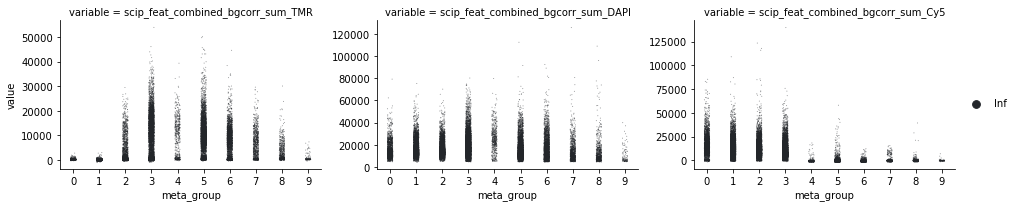

In [218]:
# SCIP features

melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_combined_bgcorr_sum_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

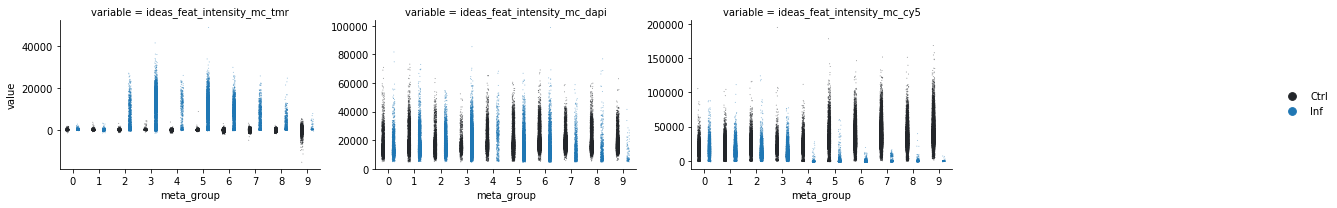

In [43]:
# IDEAS features

melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="ideas_feat_intensity_mc_(tmr|dapi|cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

## Logicle transform

I apply a logicle transform to show the bimodal distribution of intensities in the TMR and Cy5 channels.

In [220]:
for k, gdf in df.groupby("meta_group"):
    gdf = gdf[[
        "scip_feat_combined_bgcorr_sum_TMR", 
        "scip_feat_combined_bgcorr_sum_DAPI", 
        "scip_feat_combined_bgcorr_sum_Cy5"
    ]]
    transf = flowutils.transforms.logicle(gdf.values, w=1, t=200000, m=4.5, channel_indices=None)
    df.loc[(slice(None), slice(None), slice(None), k), [
        "scip_feat_combined_bgcorr_sum_logicle_TMR", 
        "scip_feat_combined_bgcorr_sum_logicle_DAPI", 
        "scip_feat_combined_bgcorr_sum_logicle_Cy5"
    ]] = transf

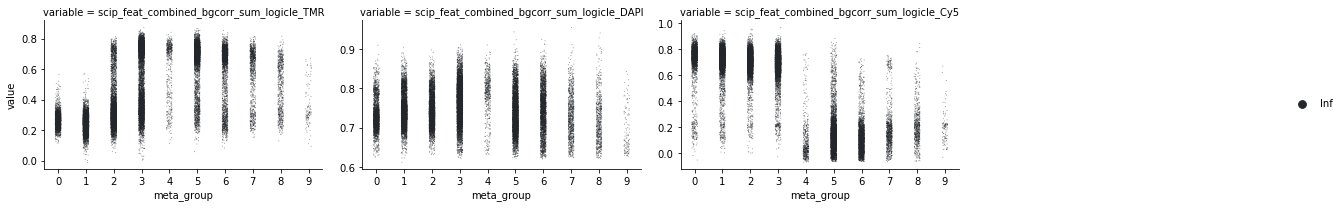

In [221]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_combined_bgcorr_sum_logicle_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

# Prediction of infection states based on all channels except TMR (= MCP) and Cy5 (= PSBA) channel

For this part of the analysis we only continue with the infected samples from all timepoints.

Class imbalance is still present in the infected samples, but a bit less severe.

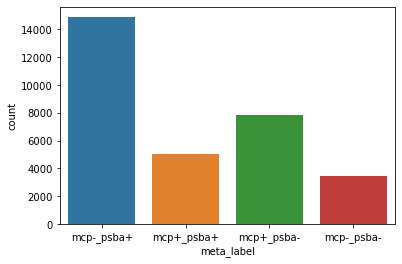

In [203]:
enc = LabelEncoder().fit(df.loc["Inf", :, :, :]["meta_label"])
y = enc.transform(df.loc["Inf", :, :, :]["meta_label"])
seaborn.countplot(x=df.loc["Inf", :, :, :]["meta_label"])

In [204]:
# selection of the generic channel features for SCIP
to_keep = df.filter(regex=".*scip.*(BF1|DAPI|SSC)$").columns
Xs = df.loc["Inf", :, :, :][to_keep]
Xs.shape

(31236, 527)

In [205]:
# selection of the generic channel features for IDEAS
to_keep_i = df.filter(regex=".*ideas.*(m01|bf|m06|ch06|m07|dapi).*").columns
to_keep_i = numpy.array([f for f in to_keep_i if not (("tmr" in f) or ("cy5" in f))]) # filter out similarity features with fluorescence channels
Xi = df.loc["Inf", :, :, :][to_keep_i]
Xi.shape

(31236, 144)

In [206]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, stratify=y, test_size=0.3, random_state=0)

In [207]:
Xi_train, Xi_test, y_train, y_test = train_test_split(Xi, y, stratify=y, test_size=0.3, random_state=0)

In [223]:
df_train, df_test = train_test_split(df.loc["Inf"], stratify=y, test_size=0.3, random_state=0)

## Classification using a support vector machine

First, I use a support vector machine (SVM) for classifying the infection states. This model performs well, but it has the downside of not being interpretable. We can not derive any new insights on what features the model uses for its prediction. I still want to test this model since it gives us a baseline performance value to compare to when I test a more interpretable model later on. To deal with the class imbalance, the class_weight parameter is set to balanced. This will cause the model to be penalized more when it makes a wrong prediction for the minority classes (= all classes except for the MCP-/PSBA+ state.

In [210]:
model_svc = make_pipeline(
    StandardScaler(),
    SVC(cache_size=4096, class_weight="balanced")
)

### Tuning C

Here I tune a hyperparameter of the SVM model.

In [599]:
%%time
scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
grid = GridSearchCV(
    model_svc,
    {
        "svc__C": [0.1, 0.5, 1, 1.5, 2, 2.5]
    },
    refit=False,
    n_jobs=30,
    cv=5,
    scoring=scoring,
    verbose=2,
    return_train_score=True
).fit(
    numpy.ascontiguousarray(Xs_train.values),
    y_train
)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 422 ms, sys: 1.53 s, total: 1.95 s
Wall time: 9min 6s


<ErrorbarContainer object of 3 artists>

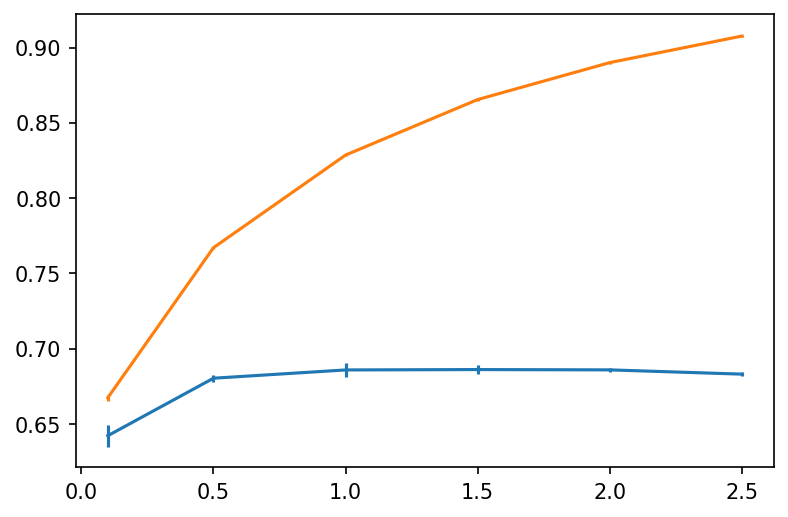

In [603]:
fig, ax = plt.subplots(dpi=150)
ax.errorbar(grid.cv_results_["param_svc__C"], grid.cv_results_["mean_test_balanced_accuracy"], yerr=grid.cv_results_["std_test_balanced_accuracy"], label="test")
ax.errorbar(grid.cv_results_["param_svc__C"], grid.cv_results_["mean_train_balanced_accuracy"], yerr=grid.cv_results_["std_train_balanced_accuracy"], label="train")

### Prediction of infection states

I fit the SVM on both IDEAS and SCIP features for comparison.

First on IDEAS features.

In [211]:
%%time
model_svc_i = clone(model_svc).fit(Xi_train, y_train)

CPU times: user 1min 9s, sys: 28.4 ms, total: 1min 9s
Wall time: 1min 9s


In [212]:
preds_i = model_svc_i.predict(Xi_test)
balanced_accuracy_score(y_test, preds_i)

0.7623160622450522

The balanced accuracy has a fairly good value. The confusion matrix below gives us more insight into where the model struggles. In the confusion matrix we want to see ideally a high value on the diagonal. On the diagonal the events are counted for which the prediction of the model agrees with the actual ground truth label. Off-diagonal counts indicate wrong predictions by the model, this indicates the model's _confusion_. Note that the matrix is normalized per row.

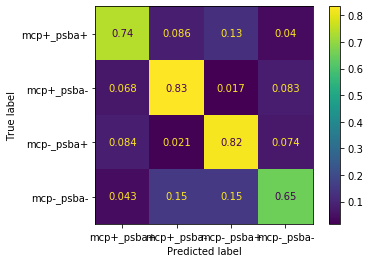

In [213]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_i, display_labels=enc.classes_, normalize='true')

Here, I fit the same model using SCIP features. Lucky for me, results are slightly better using SCIP features :-)

In [214]:
%%time
model_svc_s = clone(model_svc).fit(Xs_train.fillna(0), y_train)

CPU times: user 2min 49s, sys: 0 ns, total: 2min 49s
Wall time: 2min 49s


In [215]:
preds_s = model_svc_s.predict(Xs_test.fillna(0))
balanced_accuracy_score(y_test, preds_s)

0.7677836578905597

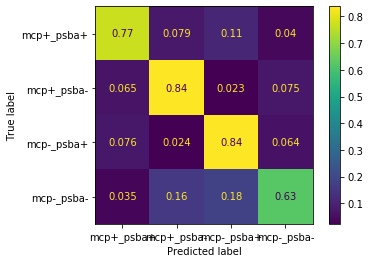

In [216]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_s, display_labels=enc.classes_, normalize='true')

Note that for both feature sets the model struggles mainly with the MCP-/PSBA- state. This was to be expected due to the limited amount of events in this state.

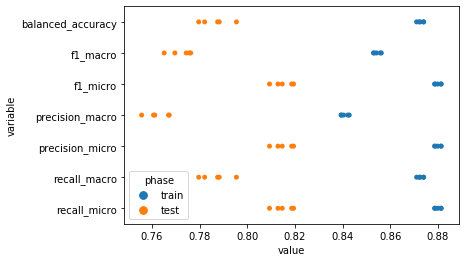

In [44]:
_ = predict_gates(Xs_train, y_train, clone(model_svc))

### Plot results

Below I show the SVM model predictions on a scatter plot of logicle-transformed TMR versus Cy5 intensity.

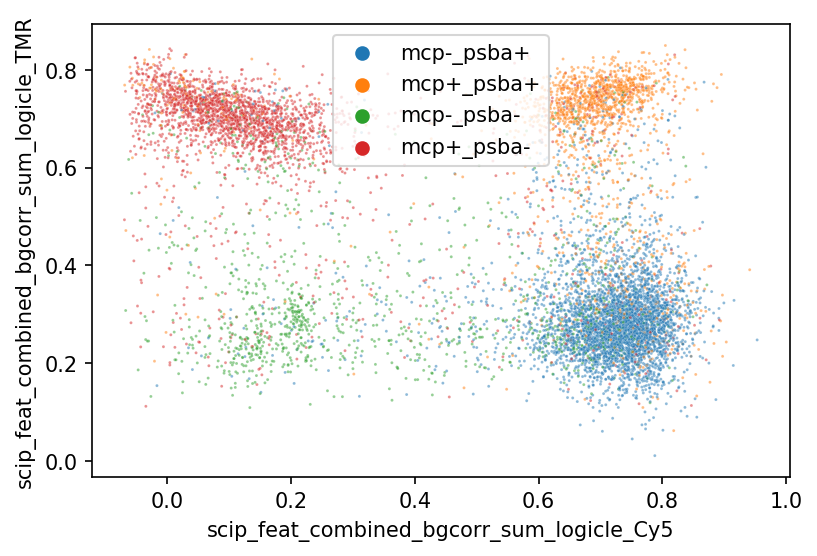

In [224]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    ax=ax,
    data=df_test, 
    x="scip_feat_combined_bgcorr_sum_logicle_Cy5", 
    y="scip_feat_combined_bgcorr_sum_logicle_TMR", 
    hue=enc.inverse_transform(preds_s), s=2, edgecolors="none", alpha=0.5)

Below is the same plot, but this time orange dots are misclassified by the model (= the model does not agree with the ground truth), blue are correctly classified. We can see that misclassifications occur relatively uniformly throughout the TMR/Cy5 input space.

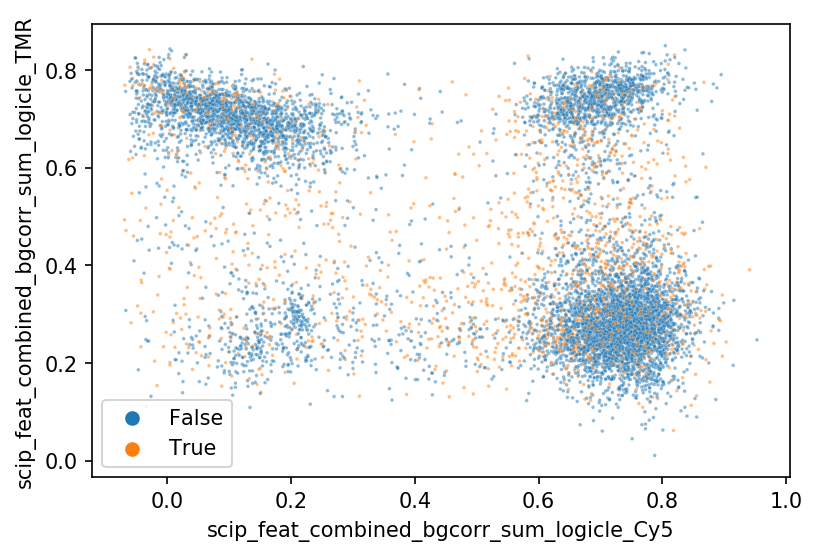

In [225]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    ax=ax,
    data=df_test, 
    x="scip_feat_combined_bgcorr_sum_logicle_Cy5", 
    y="scip_feat_combined_bgcorr_sum_logicle_TMR", 
    hue=preds_s != y_test, s=3, edgecolors="none", alpha=0.5)

## Classification using an Extreme Gradient Boosting classifier

The Extreme Gradient Boosting (XGB) classifier is also powerful model, which uses a collection of decision trees to predict the infection states. The advantage of decision trees is that they are interpretable. If I can achieve similar performance with the XGB classifier as with an SVM, we will have a decently performing and interpretable model that can give us insight into which features of the generic channels correlate with the TMR and Cy5 channels.

### Fitting XGBClassifier

Here, I fit an XGB classifier with 1000 decision trees. It reaches a balanced accuracy score of 0.76 which is reasonably close to the SVM's 0.77. Comparing the confusion matrices, we can see that the XGB classifier is struggling a bit more with MCP-/PSBA- classses than the SVM. As with the SVM, I tried to alleviate class imbalance by weighting the classes. This did not improve performance for this model.

### Tuning hyper parameters

Here I tune the learning rate hyperparameter of the XGB model.

In [226]:
import pickle
with open(data_dir / f"results/scip/202201111300/grid_2.pickle", "rb") as fh:
    grid = pickle.load(fh)

In [227]:
df = pandas.DataFrame(grid.cv_results_["params"])
df["mean_test_balanced_accuracy"] = grid.cv_results_["mean_test_balanced_accuracy"]
df["mean_train_balanced_accuracy"] = grid.cv_results_["mean_train_balanced_accuracy"]

In [228]:
import hiplot
hiplot.Experiment.from_iterable(df.to_dict(orient="records")).display()

<IPython.core.display.Javascript object>

In [229]:
model = XGBClassifier(
    booster="gbtree",  
    objective="multi:softmax", 
    eval_metric="merror",
    tree_method="gpu_hist",
    use_label_encoder=False,
    subsample=1,
    n_estimators=800,
    learning_rate=0.1,
    max_depth=5,
    colsample_bytree=0.75
).fit(Xs_train, y_train)

In [230]:
preds = model.predict(Xs_train)
balanced_accuracy_score(y_train, preds)

1.0

In [231]:
preds = model.predict(Xs_test)
balanced_accuracy_score(y_test, preds)

0.7695470413528288

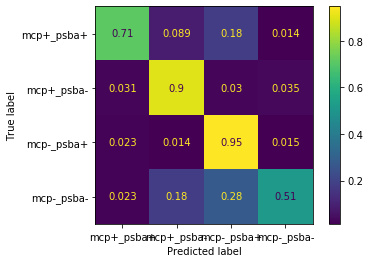

In [232]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=enc.classes_, normalize='true')

In [233]:
unique, counts = numpy.unique(y_train, return_counts=True)
class_weights = (1 - counts / counts.sum())
class_weights /= class_weights.sum()

In [234]:
enc.classes_

array(['mcp+_psba+', 'mcp+_psba-', 'mcp-_psba+', 'mcp-_psba-'],
      dtype=object)

In [235]:
class_weights

array([0.27967071, 0.24934827, 0.17447976, 0.29650126])

In [236]:
model = XGBClassifier(
    booster="gbtree",  
    objective="multi:softmax", 
    eval_metric="merror",
    tree_method="gpu_hist",
    use_label_encoder=False,
    subsample=1,
    n_estimators=800,
    learning_rate=0.1,
    max_depth=5,
    colsample_bytree=0.75,
).fit(Xs_train, y_train, sample_weight=class_weights[..., numpy.newaxis][y_train].ravel())

In [237]:
preds = model.predict(Xs_train)
balanced_accuracy_score(y_train, preds)

1.0

In [238]:
preds = model.predict(Xs_test)
balanced_accuracy_score(y_test, preds)

0.7744105948832452

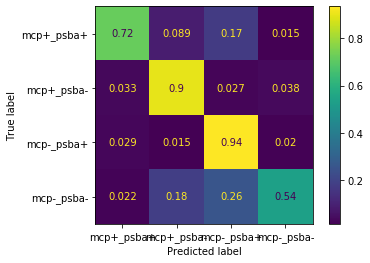

In [239]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=enc.classes_, normalize='true')

In [240]:
import joblib
joblib.dump(model, "xgb.joblib")

['xgb.joblib']

# Discussion

In this notebook I have trained a support vector machine and an extreme gradient boosting tree to predict the infection state of phtyoplankton based on the brightfield, darkfield / side scatter and DAPI signals. The SVM performed slightly better than the XGB model (0.77 versus 0.76 balanced accuracy), but lacks interpretability. In gerenal, the classification of the MCP-/PSBA- state was unsatisfactory with a recall of 0.65 and 0.53 for the SVM and XGB model, respectively.

From this initial analysis, we can conclude that it is not a trivial task to predict infection state based on the generic channels in the dataset. However, the results are good enough to warrant some more research and interpret the models further.